## 引入CliffWalking-v0环境，及环境初探

In [1]:
import gym

env = gym.make('CliffWalking-v0')   # 经典悬崖寻路环境
print('状态空间：',env.observation_space)
print('动作空间：',env.action_space)
print('状态35执行[⬆️-0,➡️-1,⬇️-2,⬅️-3]动作后的四元组，分别表示(prob ,next_state, reward, down):')
env.P[35]

状态空间： Discrete(48)
动作空间： Discrete(4)
状态35执行[⬆️-0,➡️-1,⬇️-2,⬅️-3]动作后的四元组，分别表示(prob ,next_state, reward, down):


{0: [(1.0, 23, -1, False)],
 1: [(1.0, 35, -1, False)],
 2: [(1.0, 47, -1, True)],
 3: [(1.0, 34, -1, False)]}

In [2]:
env.reset()
env.render()

/home/xue/.conda/envs/dmc/lib/python3.10/site-packages/gym/envs/toy_text/cliffwalking.py:167: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("CliffWalking-v0", render_mode="rgb_array")
  logger.warn(


## 1. Solving CliffWalking-v0 via Sarsa

In [3]:
import numpy as np
import random


def select_action_behavior_policy(action_value_set, epsilon):
    '''使用epsilon-greedy采样action'''
    prob = random.random()
    if prob > epsilon:  action = np.argmax(action_value_set)
    else:  action = random.randint(0,3)
    return action
    
def Sarsa(env, alpha=0.2, epsilon_scope=[0.2,0.05,0.99], num_of_episode=1000, gamma=0.9, Q_table=None):
    '''
    Sarsa算法,返回Q表和估计的最优策略
    其中epsilon_scope由高到低衰减,从左到右分别是[最高值,最低值,衰减因子]
    '''
    epsilon = epsilon_scope[0]
    # 1. 初始化Q表
    if Q_table is None: Q = np.zeros( (env.nS, env.nA), dtype=np.float )
    else: Q = Q_table  # 方便后续作图，不做图的话可以忽略本行和Q_table形参
    sum_reward = 0
    for num in range(num_of_episode):
#         sum_reward = 0
        state = env.reset()  # Init S
        # 2.通过behavior policy采样初始state下的action
        action = select_action_behavior_policy(Q[state], epsilon)
        while True:
            # 3.执行action并观察R和next state
            next_state, reward, done, info = env.step(action)
            # 4.再次通过behavior policy采样next_action
            next_action = select_action_behavior_policy(Q[next_state], epsilon)
            # 5.更新Q(S,A),使用下一个状态-动作二元组更新
            Q[state][action] += alpha * (reward + gamma*Q[next_state][next_action]  - Q[state][action])
            sum_reward += reward
            if done: break
            state, action = next_state, next_action
        # 对epsilon进行衰减
        if epsilon >= epsilon_scope[1]: epsilon *= epsilon_scope[2]
#         if num % 20 == 0:  print("Episode: {}, Score: {}".format(num, sum_reward))
    return Q, sum_reward

def get_optimal_policy(env, Q):
    '''从Q表中得到最优策略'''
    nS = Q.shape[0]
    policy = np.full(nS, 0)  # 初始化为全0元素
    for state in range(nS):
        action = np.argmax( Q[state] )
        next_state = env.P[state][action][0][1]
        policy[state] = action
    return policy
        
def print_policy(policy):
    print("\n【Sarsa Optimal Policy】：")
    for i, p in enumerate(policy):
        if i % 12 == 0 and i != 0:  print()
        if p == 0: print('⬆️', end=' ')
        elif p == 1: print('➡️', end=' ')
        elif p == 2: print('⬇️', end=' ')
        elif p == 3: print('⬅️', end=' ')
    
    
env = gym.make('CliffWalking-v0')   # 经典悬崖寻路环境  
# Q-learning学习出Q表
Q_table, _ = Sarsa(env, alpha=0.2, epsilon_scope=[0.2,0.05,0.99], num_of_episode=2000, gamma=0.9)
# 通过训练好的Q表获取最优policy
policy = get_optimal_policy(env, Q_table)
# 打印最优policy
print_policy(policy)


【Sarsa Optimal Policy】：
➡️ ➡️ ➡️ ➡️ ➡️ ➡️ ➡️ ➡️ ➡️ ➡️ ➡️ ⬇️ 
⬆️ ⬆️ ➡️ ⬅️ ➡️ ⬆️ ➡️ ➡️ ➡️ ➡️ ➡️ ⬇️ 
⬆️ ➡️ ⬆️ ⬆️ ⬆️ ⬆️ ➡️ ⬆️ ⬆️ ⬆️ ➡️ ⬇️ 
⬆️ ⬆️ ⬆️ ⬆️ ⬆️ ⬆️ ⬆️ ⬆️ ⬆️ ⬆️ ⬆️ ⬆️ 

## 2. Solving CliffWalking-v0 via Q-learning

In [4]:
import numpy as np
import random


def select_action_behavior_policy(action_value_set, epsilon):
    '''使用epsilon-greedy采样action'''
    prob = random.random()
    if prob > epsilon:  action = np.argmax(action_value_set)
    else:  action = random.randint(0,3)
    return action
    
def Q_learning(env, alpha=0.2, epsilon_scope=[0.2,0.05,0.99], num_of_episode=1000, gamma=0.9, Q_table=None):
    '''
    Q学习算法,返回Q表和估计的最优策略
    其中epsilon_scope由高到低衰减,从左到右分别是[最高值,最低值,衰减因子]
    '''
    epsilon = epsilon_scope[0]
    # 1. 初始化Q表
    if Q_table is None: Q = np.zeros( (env.nS, env.nA), dtype=np.float )
    else: Q = Q_table
    sum_reward = 0
    for num in range(num_of_episode):
#         sum_reward = 0
        state = env.reset()  # Init S
        while True:
            # 2.通过behavior policy采样action
            action = select_action_behavior_policy(Q[state], epsilon)
            # 3.执行action并观察R和next state
            next_state, reward, done, info = env.step(action)
            # 4.更新Q(S,A),使用max操作更新
            Q[state][action] += alpha * (reward + gamma*max( Q[next_state] ) - Q[state][action])
            sum_reward += reward
            if done: break
            state = next_state
        # 对epsilon进行衰减
        if epsilon >= epsilon_scope[1]: epsilon *= epsilon_scope[2]
        # if num % 20 == 0:  print("Episode: {}, Score: {}".format(num, sum_reward))
    return Q, sum_reward

def get_optimal_policy(env, Q):
    '''从Q表中得到最优策略'''
    nS = Q.shape[0]
    policy = np.full(nS, 0)  # 初始化为全0元素
    for state in range(nS):
        action = np.argmax( Q[state] )
        next_state = env.P[state][action][0][1]
        policy[state] = action
    return policy
        
def print_policy(policy):
    print("\n【Q-learning Optimal Policy】：")
    for i, p in enumerate(policy):
        if i % 12 == 0 and i != 0:  print()
        if p == 0: print('⬆️', end=' ')
        elif p == 1: print('➡️', end=' ')
        elif p == 2: print('⬇️', end=' ')
        elif p == 3: print('⬅️', end=' ')
    
    
env = gym.make('CliffWalking-v0')   # 经典悬崖寻路环境  
# Q-learning学习出Q表
Q_table, _ = Q_learning(env, alpha=0.2, epsilon_scope=[0.2,0.05,0.99], num_of_episode=1000, gamma=0.9)
# 通过训练好的Q表获取最优policy
policy = get_optimal_policy(env, Q_table)
# 打印最优policy
print_policy(policy)


【Q-learning Optimal Policy】：
⬆️ ➡️ ⬅️ ⬅️ ⬇️ ➡️ ➡️ ➡️ ➡️ ➡️ ⬅️ ⬇️ 
⬇️ ⬇️ ➡️ ➡️ ➡️ ⬇️ ⬇️ ➡️ ➡️ ➡️ ➡️ ⬇️ 
➡️ ➡️ ➡️ ➡️ ➡️ ➡️ ➡️ ➡️ ➡️ ➡️ ➡️ ⬇️ 
⬆️ ⬆️ ⬆️ ⬆️ ⬆️ ⬆️ ⬆️ ⬆️ ⬆️ ⬆️ ⬆️ ⬆️ 

- ## 两种算法Average reward对比

100%|██████████| 500/500 [00:15<00:00, 34.04it/s]


<IPython.core.display.Javascript object>


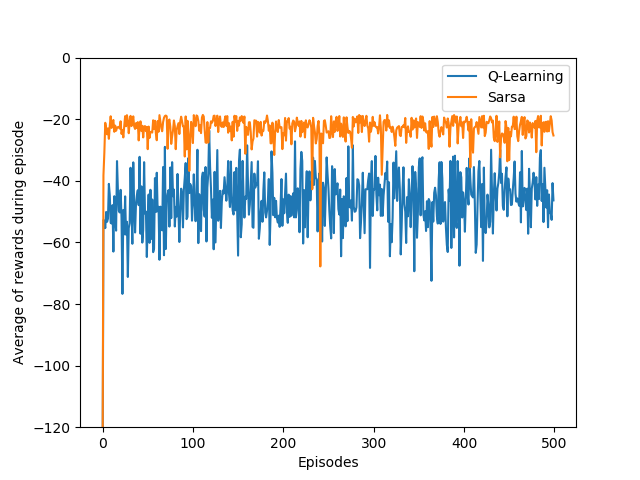

In [5]:
from tqdm import tqdm
import matplotlib
matplotlib.use('nbAgg')
import matplotlib.pyplot as plt
import matplotlib as mpl
def plot_Sarsa_and_Q_learning(env, episodes=500, runs=50):
    '''绘图Q-learning'''
    Sarsa_table, Q_learning_table, Sarsa_average_reward, Q_learning_average_reward = None, None, [], []
    for i in tqdm(range(episodes)):
        Sarsa_table, Sarsa_sum_reward = Sarsa(env, alpha=0.2, epsilon_scope=[0.1,0.1,0.99], num_of_episode=runs, gamma=0.9, Q_table=Sarsa_table)
        Q_learning_table, Q_learning_sum_reward = Q_learning(env, alpha=0.2, epsilon_scope=[0.1,0.1,0.99], num_of_episode=runs, gamma=0.9, Q_table=Q_learning_table)
        Sarsa_average_reward.append(Sarsa_sum_reward/runs) 
        Q_learning_average_reward.append(Q_learning_sum_reward/runs) 
    plt.plot(Q_learning_average_reward, label='Q-Learning')
    plt.plot(Sarsa_average_reward, label='Sarsa')
    plt.xlabel('Episodes')
    plt.ylabel('Average of rewards during episode')
    plt.ylim([-120, 0])
    plt.legend()
    plt.show()
    plt.close()
        
env.reset()
plot_Sarsa_and_Q_learning(env, episodes=500, runs=60)

- ## 两种算法耗时对比

In [6]:
from timeit import repeat

consum_time = repeat( lambda:Q_learning(env, 0.2, [0.2,0.05,0.99], 1000, gamma=0.9), number=1, repeat=3 )
print('\nQ-learning在CliffWalking-v0任务上的最短耗时：%.4f秒' % ( min(consum_time) ) )
consum_time = repeat( lambda:Sarsa(env, 0.2, [0.2,0.05,0.99], 1000, gamma=0.9), number=1, repeat=3 )
print('\nSarsa在CliffWalking-v0任务上的最短耗时：%.4f秒' % ( min(consum_time) ) )


Q-learning在CliffWalking-v0任务上的最短耗时：0.3044秒

Sarsa在CliffWalking-v0任务上的最短耗时：0.2843秒


## 3. Double Q-learning

超参数

In [107]:
import os 
import random
import numpy as np

# VQ_alpha = 10
# init_factor = 1.0
# factor = init_factor
num_of_episode = 300
x_interval = int(num_of_episode/10)
v_noise = 0.01
sigma = 0.0
mu = -0.1
nB = 20
rbs = 100  # replay buffer size
bs = 8  # batch size
# n_state_space = 3

# save_path = f"/storage/xue/repos/Reinforcement_Learning/images/ex6.7/Q_DQ_VQ/VQ_factor_{VQ_alpha}_E_{num_of_episode}"
# os.makedirs(save_path, exist_ok=True)

save_path = None

# note = f"factor={VQ_alpha}, n_episode={num_of_episode}"
note = ""

- 构建环境

In [109]:
class Env():                   
    '''构造一个环境类'''        
    def __init__(self, nB, mu, sigma, ):  
        self.mu = mu
        self.sigma = sigma
        self.states = list(np.arange(3))
        # self.states = [-5,-4,-3,-2,-1,0]
        self.left = 0
        self.right = 1
        
        self.nS = len(self.states)   
        self.nA = 2
        self.nB = nB  # 状态B的动作数

        self.state = self.states[-1] 
        self.STATE_A = self.states[-1]
        self.STATE_B = self.states[1]
        self.Terminal = self.states[0]
        
    def reset(self):
        self.state = self.states[-1]
        return self.state
    
    def step(self, action):
        if self.state == self.STATE_B:
            self.state = self.Terminal
            if self.sigma>0.0:
                reward = np.random.normal(self.mu, self.sigma)
            else:
                reward = self.mu
            return self.state, reward, True
        else:
            if action == self.left:
                self.state -= 1
                return self.state, 0, False
            elif action == self.right:
                self.state += 1
                if self.state > self.STATE_A:
                    self.state = self.Terminal
                    return self.state, 0, True
                else:
                    return self.state, 0, False
        
# class Env():                   
#     '''构造一个环境类'''        
#     def __init__(self, mu, sigma, nB, random_reward=True):  
#         self.mu = mu
#         self.sigma = sigma
#         self.STATE_A = self.left = 0
#         self.STATE_B = self.right = 1
#         self.Terminal = 2
#         self.nS = 3   # 加上Terminal即3个状态
#         self.nA = 2
#         self.nB = nB  # 状态B的动作数
#         self.state = self.STATE_A 
#         self.random_reward = random_reward
        
#     def reset(self):
#         self.state = self.STATE_A
#         return self.state
        
#     def step(self, action):
#         # A--left
#         if self.state == self.STATE_A and action == self.left:
#             self.state = self.STATE_B
#             return self.state, 0, False  # next_state, reward, done
#         # A--right
#         elif self.state == self.STATE_A and action == self.right:
#             self.state = self.Terminal
#             return self.state, 0, True
#         # B--all_actions
#         elif self.state == self.STATE_B:
#             self.state = self.Terminal
#             # reward = random.normalvariate(self.mu, self.sigma)
#             if self.random_reward:
#                 reward = np.random.normal(self.mu, self.sigma)
#             else:
#                 reward = self.mu

#             return self.state, reward, True 
# env = Env(-0.1, 1, 10, env_random_reward)   # mu, sigma, nB

- 初始化Q表+采样动作函数定义

In [12]:
import numpy as np
import random

def init_Q_table(env):
    '''初始化Q表'''
    # Q = {env.STATE_A:{action:0 for action in range(env.nA)},
    #      env.STATE_B:{action:0 for action in range(env.nB)},
    #      env.Terminal:{action:0 for action in range(env.nA)}}
    Q = {env.STATE_A:{action:np.random.normal(0,0.1) for action in range(env.nA)},
         env.STATE_B:{action:np.random.normal(0,0.1) for action in range(env.nB)},
         env.Terminal:{action:0 for action in range(env.nA)}}
    
    # from collections import UserDict
    # class Q_table(UserDict):
    #     def __getitem__(self, key):
    #         value = super().__getitem__(key)
    #         # add a Gaussian noise to the value
    #         return np.random.normal(value, 0.1) 
    # Q = {env.STATE_A:Q_table({action:0 for action in range(env.nA)}),
    #      env.STATE_B:Q_table({action:0 for action in range(env.nB)}),
    #      env.Terminal:Q_table({action:0 for action in range(env.nA)})}        

    return Q

def select_action_behavior_policy(action_value_dict, epsilon):
    '''使用epsilon-greedy采样action'''
    if random.random() > epsilon:   
        max_keys = [key for key, value in action_value_dict.items() if value == max( action_value_dict.values() )]
        action = random.choice(max_keys)
    else:  
        # 从Q字典对应state中随机选取1个动作,由于返回list,因此通过[0]获取元素
        action = random.sample(action_value_dict.keys(), 1)[0]
    return action

In [68]:
def init_V_table(env):
    '''初始化V表'''
    # V = {env.STATE_A:0, env.STATE_B:0, env.Terminal:0}
    V = {env.STATE_A:np.random.normal(0,0.1), env.STATE_B:np.random.normal(0,0.1), env.Terminal:0}

    # from collections import UserDict
    # class V_table(UserDict):
    #     def __getitem__(self, key):
    #         value = super().__getitem__(key)
    #         # add a Gaussian noise to the value
    #         return np.random.normal(value, 0.1)
    # V = V_table(V)
    
    return V

- ### Q-learning算法实现

In [5]:
def Q_learning(env, alpha=0.2, epsilon_scope=[0.2,0.05,0.99], num_of_episode=1000, gamma=0.9):
    '''
    Q学习算法,返回Q表和估计的最优策略
    其中epsilon_scope由高到低衰减,从左到右分别是[最高值,最低值,衰减因子]
    '''
    epsilon = epsilon_scope[0]
    # 1. 初始化Q表
    Q = init_Q_table(env)
    for num in range(num_of_episode):
        state = env.reset()  # Init S
        while True:
            # 2.通过behavior policy采样action
            action = select_action_behavior_policy(Q[state], epsilon)
            # 3.执行action并观察R和next state
            next_state, reward, done = env.step(action)
            # 4.更新Q(S,A),使用max操作更新
            Q[state][action] += alpha * (reward + gamma*max( Q[next_state].values() ) - Q[state][action])  
            if done: break
            state = next_state
        # 对epsilon进行衰减
        if epsilon >= epsilon_scope[1]: epsilon *= epsilon_scope[2]
    return Q


# env = Env(-0.1, 1, 10)   
# Q-learning学习出Q表
Q_table = Q_learning(env, alpha=0.2, epsilon_scope=[0.2,0.05,0.99], num_of_episode=num_of_episode, gamma=0.9)  
Q_table

NameError: name 'env' is not defined

- ### Double Q-learning算法实现

In [6]:
def get_Q1_add_Q2(Q1_state_dict, Q2_state_dict):
    '''返回Q1[state]+Q2[state]'''
    return {action: Q1_value + Q2_state_dict[action] for action, Q1_value in Q1_state_dict.items()}

def double_Q_learning(env, alpha=0.2, epsilon_scope=[0.2,0.05,0.99], num_of_episode=1000, gamma=0.9):
    '''
    双Q学习算法,返回Q表和估计的最优策略
    其中epsilon_scope由高到低衰减,从左到右分别是[最高值,最低值,衰减因子]
    '''
    epsilon = epsilon_scope[0]
    # 1. 初始化Q1表和Q2表
    Q1 = init_Q_table(env)
    Q2 = init_Q_table(env)
    for num in range(num_of_episode):
        state = env.reset()  # Init S
        while True:
            # 2.通过behavior policy采样action
            add_Q1_Q2_state = get_Q1_add_Q2(Q1[state], Q1[state])
            action = select_action_behavior_policy(add_Q1_Q2_state, epsilon)
            # 3.执行action并观察R和next state
            next_state, reward, done = env.step(action)
            # 4.更新Q(S,A),使用max操作更新
            if random.random() >= 0.5:
                # 从Q1表中的下一步state找出状态价值最高对应的action视为Q1[state]的最优动作
                A1 = random.choice( [action for action, value in Q1[next_state].items() if value == max( Q1[next_state].values() )] )
                # 将Q1[state]得到的最优动作A1代入到Q2[state][A1]中的值作为Q1[state]的更新
                Q1[state][action] += alpha * (reward + gamma*Q2[next_state][A1] - Q1[state][action])
            else:
                A2 = random.choice( [action for action, value in Q2[next_state].items() if value == max( Q2[next_state].values() )] )
                Q2[state][action] += alpha * (reward + gamma*Q1[next_state][A2] - Q2[state][action])
            if done: break
            state = next_state
        # 对epsilon进行衰减
        if epsilon >= epsilon_scope[1]: epsilon *= epsilon_scope[2]
    return Q1


env = Env(-0.1, 1, 10)   
# Q-learning学习出Q表
Q_table = double_Q_learning(env, alpha=0.2, epsilon_scope=[0.2,0.05,0.99], num_of_episode=num_of_episode, gamma=0.9)  
Q_table

/tmp/ipykernel_104943/337541280.py:18: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  action = random.sample(action_value_dict.keys(), 1)[0]


{0: {0: -0.007295948847333316, 1: 0.0},
 1: {0: 0,
  1: 0,
  2: -0.33885597759484803,
  3: -0.15025770188917245,
  4: -0.0562621102463453,
  5: -0.16082031842473304,
  6: 0,
  7: -0.11503566594726577,
  8: -0.04148866533701437,
  9: 0.12629680352634629},
 2: {0: 0, 1: 0}}

- ### Action Distribution思想实现

In [7]:
def Action_Distribution(env, alpha=0.2, epsilon_scope=[0.2,0.05,0.99], num_of_episode=1000, gamma=0.9):
    '''
    按当前state的动作分布选择动作,返回Q表和估计的最优策略
    其中epsilon_scope由高到低衰减,从左到右分别是[最高值,最低值,衰减因子]
    '''
    epsilon = epsilon_scope[0]
    # 1. 初始化Q表
    Q = init_Q_table(env)
    for num in range(num_of_episode):
        state = env.reset()  # Init S
        while True:
            # 2.通过behavior policy采样action
            action = select_action_behavior_policy(Q[state], epsilon)
            # 3.执行action并观察R和next state
            next_state, reward, done = env.step(action)
            # 4.更新Q(S,A),使用max操作更新
            Q[state][action] += alpha * (reward + gamma*random.choice(list( Q[next_state].values() )) - Q[state][action])
            if done: break
            state = next_state
        # 对epsilon进行衰减
        if epsilon >= epsilon_scope[1]: epsilon *= epsilon_scope[2]
    return Q


env = Env(-0.1, 1, 10)   
# Q-learning学习出Q表
Q_table = Action_Distribution(env, alpha=0.2, epsilon_scope=[0.2,0.05,0.99], num_of_episode=num_of_episode, gamma=0.9)  
Q_table

/tmp/ipykernel_104943/337541280.py:18: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  action = random.sample(action_value_dict.keys(), 1)[0]


{0: {0: -0.08594918812878434, 1: 0.0},
 1: {0: -0.28786286528194854,
  1: -0.0425743947715088,
  2: -0.033956998219556216,
  3: -0.08544394190562216,
  4: -0.15127841226608038,
  5: -0.08764869413864282,
  6: -0.022605756652346806,
  7: -0.034475028545589856,
  8: -0.2725892967671355,
  9: -0.008958466653897374},
 2: {0: 0, 1: 0}}

- ### Expected Sarsa算法实现

In [8]:
def Expected_Sarsa(env, alpha=0.2, epsilon_scope=[0.2,0.05,0.99], num_of_episode=1000, gamma=0.9):
    '''
    期望Sarsa算法,返回Q表和估计的最优策略
    其中epsilon_scope由高到低衰减,从左到右分别是[最高值,最低值,衰减因子]
    '''
    epsilon = epsilon_scope[0]
    # 1. 初始化Q表
    Q = init_Q_table(env)
    for num in range(num_of_episode):
        state = env.reset()  # Init S
        while True:
            # 2.通过behavior policy采样action
            action = select_action_behavior_policy(Q[state], epsilon)
            # 3.执行action并观察R和next state
            next_state, reward, done = env.step(action)
            # 4.更新Q(S,A),使用max操作更新
            Q[state][action] += alpha * (reward + gamma*sum( Q[next_state].values() ) / len(Q[next_state]) - Q[state][action])  
            if done: break
            state = next_state
        # 对epsilon进行衰减
        if epsilon >= epsilon_scope[1]: epsilon *= epsilon_scope[2]
    return Q


env = Env(-0.1, 1, 10)   
# Q-learning学习出Q表
Q_table = Expected_Sarsa(env, alpha=0.2, epsilon_scope=[0.2,0.05,0.99], num_of_episode=num_of_episode, gamma=0.9)  
Q_table

/tmp/ipykernel_104943/337541280.py:18: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  action = random.sample(action_value_dict.keys(), 1)[0]


{0: {0: -0.02606860581353919, 1: 0.0},
 1: {0: 0,
  1: 0,
  2: -0.006336220113806967,
  3: -0.19408179332063777,
  4: 0.40574709004091636,
  5: -0.22191572392106385,
  6: -0.035470087136664843,
  7: -0.00034739374444205107,
  8: -0.0797220351792353,
  9: -0.13477162702698497},
 2: {0: 0, 1: 0}}

## TD-Learing Summary

In [69]:
def TD_learning(env, method='Q-Learning', alpha_scope=[0.1, 0.01, 0.99], epsilon_scope=[0.2,0.001,0.99], v_factor_scope=[1.0, 0.001, 0.98], num_of_episode=1000, gamma=0.9, value_noise=v_noise):
    '''
    TD学习算法,返回Q表和估计的最优策略
    其中epsilon_scope由高到低衰减,从左到右分别是[最高值,最低值,衰减因子]
    '''
    epsilon = epsilon_scope[0]
    alpha = alpha_scope[0]
    v_factor = v_factor_scope[0]
    # 1. 初始化Q1表和Q2表
    Q = init_Q_table(env)
    V = init_V_table(env)
    if method == 'Double-Q':
        Q2 = init_Q_table(env)
    bool_A_left = np.zeros(num_of_episode)
    Aleft_Q_values = []
    Aright_Q_values = []
    v_errors = []
    B_max_Q_values = []
    B_mean_Q_values = []
    A_V_values = []
    B_V_values = []
    episode_rewards = []
    alpha_values = []
    epsilon_values = []
    mean_reward_B = 0
    visit_B = 0
    diff_VQ = []
    for num in range(num_of_episode):
        state = env.reset()  # Init S
        episode_reward = 0
        
        while True:
            # 2.通过behavior policy采样action
            if method == 'Double-Q':
                add_Q1_Q2_state = {action: Q1_value + Q2[state][action] for action, Q1_value in Q[state].items()}
                action = select_action_behavior_policy(add_Q1_Q2_state, epsilon)
            else: action = select_action_behavior_policy(Q[state], epsilon)
            if state == env.STATE_A and action == env.left:  
                bool_A_left[int(num)] += 1
            # 3.执行action并观察R和next state
            next_state, reward, done = env.step(action)
            if state == env.STATE_B:
                visit_B += 1
                mean_reward_B = (mean_reward_B*(visit_B-1) + reward) / visit_B
            episode_reward += reward
            # 4.更新Q(S,A),使用max操作更新
            v_error = alpha * (reward + gamma*V[next_state] - V[state])
            V[state] += v_error            
            if method == 'Q-Learning':
                q_error = alpha * (reward + gamma*max( Q[next_state].values() ) - Q[state][action])
                Q[state][action] += q_error
            elif method == "VQ-Learning":
                # factor = init_factor * (1-num/num_of_episode)
                error = (1-v_factor)*(reward + gamma*max(Q[next_state].values()) - Q[state][action]) + v_factor*(reward + gamma*V[next_state]- Q[state][action])
                Q[state][action] += alpha * error
                # Q[state][action] += alpha * (reward + gamma*max( Q[next_state].values() ) - Q[state][action])
                # Q[state][action] += alpha * (reward + gamma*V[next_state]- Q[state][action]) * factor
                # Q[state][action] += alpha * ((reward + gamma*max( Q[next_state].values() ) - Q[state][action]) + (reward + gamma*V[next_state]- Q[state][action]))
            elif method == 'Sarsa':
                action_prime = select_action_behavior_policy(Q[next_state], epsilon)
                Q[state][action] += alpha * (reward + gamma*Q[next_state][action_prime] - Q[state][action])
            elif method == 'Expected_Sarsa':
                Q[state][action] += alpha * (reward + gamma*sum( Q[next_state].values() ) / len(Q[next_state]) - Q[state][action])  
            elif method == 'Action_Distribution':
                Q[state][action] += alpha * (reward + gamma*random.choice(list( Q[next_state].values() )) - Q[state][action])
            elif method == 'Double-Q':
                # Q[state][action] += alpha * (reward + gamma*V[next_state]- Q[state][action])
                # Q2[state][action] += alpha * (reward + gamma*V[next_state]- Q2[state][action]) * 1000

                if random.random() >= 0.5:
                    # 从Q1表中的下一步state找出状态价值最高对应的action视为Q1[state]的最优动作
                    A1 = random.choice( [action for action, value in Q[next_state].items() if value == max( Q[next_state].values() )] )
                    # 将Q1[state]得到的最优动作A1代入到Q2[state][A1]中的值作为Q1[state]的更新
                    Q[state][action] += alpha * (reward + gamma*Q2[next_state][A1] - Q[state][action])
                else:
                    A2 = random.choice( [action for action, value in Q2[next_state].items() if value == max( Q2[next_state].values() )] )
                    Q2[state][action] += alpha * (reward + gamma*Q[next_state][A2] - Q2[state][action])
            # if state == env.STATE_B:
            #     print("R, v_error, V_B: ",round(reward, 5), round(v_error, 5), round(V[state], 5))
            #     print("action, q_error, Q: ", action, q_error, Q[state])
            #     print("===================")
            if done: break
            state = next_state
            
        Aleft_Q_values.append(Q[env.STATE_A][env.left])
        Aright_Q_values.append(Q[env.STATE_A][env.right])
        B_max_Q_values.append(max(Q[env.STATE_B].values()))
        B_mean_Q_values.append(sum(Q[env.STATE_B].values()) / len(Q[env.STATE_B]))
        A_V_values.append(V[env.STATE_A])
        B_V_values.append(V[env.STATE_B])
        v_errors.append(v_error)
        episode_rewards.append(episode_reward)
        alpha_values.append(alpha)
        epsilon_values.append(epsilon)
        diff_VQ.append(V[env.STATE_A] - Q[env.STATE_A][env.left])
        # 对epsilon进行衰减
        if epsilon >= epsilon_scope[1]: epsilon *= epsilon_scope[2]
        if alpha >= alpha_scope[1]: alpha *= alpha_scope[2]
        if v_factor >= v_factor_scope[1]: v_factor *= v_factor_scope[2]
        if value_noise>0.0:
            for state, actions in Q.items():
                for action, value in actions.items():
                    Q[state][action] = np.random.normal(Q[state][action], value_noise)
                    if method == 'Double-Q':
                        Q2[state][action] = np.random.normal(Q2[state][action], value_noise)
            for state, value in V.items():
                V[state] = np.random.normal(V[state], value_noise)
        # if num % 20 == 0:  print("Episode: {}, Score: {}".format(num, sum_reward))
    # convert into numpy array
    Aleft_Q_values = np.array(Aleft_Q_values)
    Aright_Q_values = np.array(Aright_Q_values)
    B_max_Q_values = np.array(B_max_Q_values)
    B_mean_Q_values = np.array(B_mean_Q_values)
    A_V_values = np.array(A_V_values)
    B_V_values = np.array(B_V_values)
    episode_rewards = np.array(episode_rewards)
    alpha_values = np.array(alpha_values)
    epsilon_values = np.array(epsilon_values)
    v_errors = np.array(v_errors)
    diff_VQ = np.array(diff_VQ)
    # print(bool_A_left.shape, Aleft_Q_values.shape, B_max_Q_values.shape, A_V_values.shape, B_V_values.shape)
    # return {"VA": A_V_values, "VB":B_V_values}, bool_A_left, Aleft_Q_values, B_max_Q_values
    return {"A_V": A_V_values, "B_V":B_V_values, "bool_A_left": bool_A_left, "Aleft_Q_values": Aleft_Q_values, "Aright_Q_values": v_errors, "B_max_Q_values": diff_VQ, "B_mean_Q_values": B_mean_Q_values, "episode_rewards": episode_rewards, "alpha_values": alpha_values, "epsilon_values": epsilon_values, "Q": Q, "V": V,
            "mean_reward_B": mean_reward_B}


# method = ['Q-Learning', 'Expected_Sarsa', 'Action_Distribution', 'Double-Q']
env = Env(mu=-0.1, sigma=1.0, nB=100)   
# Q-learning学习出Q表
# output = TD_learning(env, method='Q-Learning', alpha_scope=[0.1, 0.001, 1.0], epsilon_scope=[0.1, 0.001, 1.0], num_of_episode=num_of_episode, gamma=1.0)  
# print("output['mean_reward_B']:",output['mean_reward_B'])
# print(output['Q'])
# print(output['V'])

## Create Replay Buffer, Q table, V table

In [110]:
class Buffer():
    def __init__(self, size, batch_size):
        self.obs = np.zeros([size], dtype=np.int32)
        self.n_obs = np.zeros([size], dtype=np.int32)
        self.act = np.zeros([size], dtype=np.int32)
        self.rew = np.zeros([size], dtype=np.float32)
        self.done = np.zeros([size], dtype=np.bool)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0
        
    def store(
        self,
        obs: np.ndarray,
        act: np.ndarray, 
        rew: float, 
        next_obs: np.ndarray, 
        done: bool,
    ):
        self.obs[self.ptr] = obs
        self.n_obs[self.ptr] = next_obs
        self.act[self.ptr] = act
        self.rew[self.ptr] = rew
        self.done[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self):
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)
        return dict(obs=self.obs[idxs],
                    n_obs=self.n_obs[idxs],
                    act=self.act[idxs],
                    rew=self.rew[idxs],
                    done=self.done[idxs])

    def __len__(self) -> int:
        return self.size

def init_Q_table(env):
    '''初始化Q表'''
    # Q = {env.STATE_A:{action:0 for action in range(env.nA)},
    #      env.STATE_B:{action:0 for action in range(env.nB)},
    #      env.Terminal:{action:0 for action in range(env.nA)}}
    # Q = {env.STATE_A:{action:np.random.normal(0,0.1) for action in range(env.nA)},
    #      env.STATE_B:{action:np.random.normal(0,0.1) for action in range(env.nB)},
    #      env.Terminal:{action:0 for action in range(env.nA)}}
    action_size = max(env.nA, env.nB)
    Q = np.zeros([env.nS, action_size])
    
    return Q

def init_V_table(env):
    V = np.zeros([env.nS])
    return V

# def select_action(state, epsilon, Q, env):
#     if state == env.STATE_A:
#         action_space_n = env.nA
#     elif state == env.STATE_B:
#         action_space_n = env.nB
#     if random.random() > epsilon:
#         value = np.max(Q[state][:action_space_n])
#         action = np.random.choice(np.where(Q[state][:env.nB] == value)[0])
#     else:
#         action = np.random.choice(action_space_n)

def select_action(action_values, epsilon):
    if np.random.random() > epsilon:
        value = np.max(action_values)
        action = random.choice(np.argwhere(action_values == value))[0]
    else:
        action = np.random.choice(len(action_values))
    return action

        


In [67]:
import random

def TD_learning_Replay(env:Env, method='Q-Learning', alpha_scope=[0.1, 0.01, 0.99], epsilon_scope=[0.2,0.001,0.99], v_factor_scope=[1.0, 0.001, 0.98], num_of_episode=1000, gamma=0.9, value_noise=0.0, rbs=100, bs=8):
    '''
    TD学习算法,返回Q表和估计的最优策略
    其中epsilon_scope由高到低衰减,从左到右分别是[最高值,最低值,衰减因子]
    '''
    epsilon = epsilon_scope[0]
    alpha = alpha_scope[0]
    v_factor = v_factor_scope[0]
    # 1. 初始化Q1表和Q2表
    Q = init_Q_table(env)
    V = init_V_table(env)
    buffer = Buffer(size=rbs, batch_size=bs)
    if method == 'Double-Q':
        Q2 = init_Q_table(env)
    bool_A_left = np.zeros(num_of_episode)
    bool_A_right = np.zeros(num_of_episode)
    Aleft_Q_values = []
    Aright_Q_values = []
    v_errors = []
    B_max_Q_values = []
    B_mean_Q_values = []
    A_V_values = []
    B_V_values = []
    episode_rewards = []
    alpha_values = []
    epsilon_values = []
    mean_reward_B = 0
    visit_B = 0
    diff_VQ = []
    for num in range(num_of_episode):
        state = env.reset()  # Init S
        episode_reward = 0
        
        while True:
            if method == 'Double-Q':
                Q_values = (Q+Q2)/2
            else:
                Q_values = Q
            if state == env.STATE_B:
                action = select_action(Q_values[state][:env.nB], epsilon)
            else:
                action = select_action(Q_values[state][:env.nA], epsilon)

            if state == env.STATE_A and action == env.left:  
                bool_A_left[int(num)] += 1
            if state == env.STATE_A and action == env.right:
                bool_A_right[int(num)] += 1
                
            next_state, reward, done = env.step(action)
            buffer.store(state, action, reward, next_state, done)
            if state == env.STATE_B:
                visit_B += 1
                mean_reward_B = (mean_reward_B*(visit_B-1) + reward) / visit_B
            episode_reward += reward
            if len(buffer) >= buffer.batch_size:
                dict = buffer.sample_batch()    
                b_obs, b_act, b_rew, b_nobs, b_done = dict['obs'], dict['act'], dict['rew'], dict['n_obs'], dict['done']   
                b_done = b_done.astype(int)
                if method == 'Q-Learning':
                    # curr_q = np.take_along_axis(Q[b_obs], b_act[:, None], axis=-1).squeeze()
                    q_error = alpha * (b_rew + gamma*(1-b_done)*np.max(Q[b_nobs], axis=-1) - Q[b_obs, b_act])
                    Q[b_obs, b_act] += q_error
                elif method == "VQ-Learning":
                    v_error = alpha * (b_rew + gamma*V[b_nobs] - V[b_obs])
                    V[b_obs] += v_error   
                    v_errors.append(v_error)
                    error = (1-v_factor)*(b_rew + gamma*np.max(Q[b_nobs], axis=-1) - Q[b_obs, b_act]) + v_factor*(b_rew + gamma*V[b_nobs]- Q[b_obs, b_act])
                    Q[b_obs, b_act] += alpha * error
                    # Q[state][action] += alpha * (reward + gamma*max( Q[next_state].values() ) - Q[state][action])
                    # Q[state][action] += alpha * (reward + gamma*V[next_state]- Q[state][action]) * factor
                    # Q[state][action] += alpha * ((reward + gamma*max( Q[next_state].values() ) - Q[state][action]) + (reward + gamma*V[next_state]- Q[state][action]))
                elif method == 'Sarsa':
                    action_prime = np.array([select_action(Q[n_obs], epsilon) for n_obs in b_nobs])
                    Q[b_obs, b_act] += alpha * (b_rew + gamma*Q[b_nobs, action_prime] - Q[b_obs, b_act])
                elif method == 'Expected_Sarsa':
                    Q[b_obs, b_act] += alpha * (b_rew + gamma*np.mean(Q[b_nobs], axis=-1) - Q[b_obs, b_act])  
                elif method == 'Action_Distribution':
                    rand_next_q = np.array([np.random.choice(row) for row in Q[b_nobs]])
                    Q[b_obs, b_act] += alpha * (b_rew + gamma*rand_next_q - Q[b_obs, b_act])
                elif method == 'Double-Q':
                    # Q[state][action] += alpha * (reward + gamma*V[next_state]- Q[state][action])
                    # Q2[state][action] += alpha * (reward + gamma*V[next_state]- Q2[state][action]) * 1000
                    def get_action_indices(arr):
                        max_values = np.max(arr, axis=1)
                        max_indices = []
                        for i in range(len(arr)):
                            idx = random.choice(np.argwhere(arr[i] == max_values[i]))[0]
                            max_indices.append(idx) 
                        return np.array(max_indices)                 

                    if np.random.random() >= 0.5: 
                        A1 = get_action_indices(Q[b_nobs])
                        # 将Q1[state]得到的最优动作A1代入到Q2[state][A1]中的值作为Q1[state]的更新
                        Q[b_obs, b_act] += alpha * (b_rew + gamma*Q2[b_nobs, A1] - Q[b_obs, b_act])
                    else:
                        A2 = get_action_indices(Q2[b_nobs])
                        Q2[b_obs, b_act] += alpha * (b_rew + gamma*Q[b_nobs, A2] - Q2[b_obs, b_act])

            if done: 
                break
            state = next_state
            
        Aleft_Q_values.append(Q[env.STATE_A][env.left])
        Aright_Q_values.append(Q[env.STATE_A][env.right])
        B_max_Q_values.append(np.max(Q[env.STATE_B]))
        B_mean_Q_values.append(np.sum(Q[env.STATE_B]) / len(Q[env.STATE_B]))
        A_V_values.append(V[env.STATE_A])
        B_V_values.append(V[env.STATE_B])
        episode_rewards.append(episode_reward)
        alpha_values.append(alpha)
        epsilon_values.append(epsilon)
        diff_VQ.append(V[env.STATE_A] - Q[env.STATE_A][env.left])
        # 对epsilon进行衰减
        if epsilon >= epsilon_scope[1]: epsilon *= epsilon_scope[2]
        if alpha >= alpha_scope[1]: alpha *= alpha_scope[2]
        if v_factor >= v_factor_scope[1]: v_factor *= v_factor_scope[2]
        if value_noise>0.0:
            Q = np.random.normal(Q, value_noise)
            if method == 'Double-Q':
                Q2 = np.random.normal(Q2, value_noise)
            V = np.random.normal(V, value_noise)
    # convert into numpy array
    Aleft_Q_values = np.array(Aleft_Q_values)
    Aright_Q_values = np.array(Aright_Q_values)
    B_max_Q_values = np.array(B_max_Q_values)
    B_mean_Q_values = np.array(B_mean_Q_values)
    A_V_values = np.array(A_V_values)
    B_V_values = np.array(B_V_values)
    episode_rewards = np.array(episode_rewards)
    alpha_values = np.array(alpha_values)
    epsilon_values = np.array(epsilon_values)
    v_errors = np.array(v_errors)
    diff_VQ = np.array(diff_VQ)
    # print(bool_A_left.shape, Aleft_Q_values.shape, B_max_Q_values.shape, A_V_values.shape, B_V_values.shape)
    # return {"VA": A_V_values, "VB":B_V_values}, bool_A_left, Aleft_Q_values, B_max_Q_values
    return {"A_V": A_V_values, "B_V":B_V_values, "bool_A_left": bool_A_left, "bool_A_right": bool_A_right, "Aleft_Q_values": Aleft_Q_values, "Aright_Q_values": v_errors, "B_max_Q_values": diff_VQ, "B_mean_Q_values": B_mean_Q_values, "episode_rewards": episode_rewards, "alpha_values": alpha_values, "epsilon_values": epsilon_values, "Q": Q, "V": V,
            "mean_reward_B": mean_reward_B}


alpha_scope = [0.1, 0.001, 1.0]
epsilon_scope = [0.1, 0.001, 1.0]
v_factor_scope=[1.0, 0.001, 1.0]
gamma = 0.9

env = Env(mu=-0.1, sigma=1.0, nB=30)

output = TD_learning_Replay(env, method='Q-Learning', alpha_scope=[0.1, 0.001, 1.0], epsilon_scope=[0.1, 0.001, 1.0], v_factor_scope=v_factor_scope, num_of_episode=num_of_episode, gamma=gamma)  
# print("output['mean_reward_B']:",output['mean_reward_B'])
# print(output['Q'])
# print(output['V'])

/tmp/ipykernel_459961/990067124.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.done = np.zeros([size], dtype=np.bool)


## Evaluation of methods

In [111]:
from tqdm import tqdm

total_num = 500

prob_Q_A_left, A_left_Q_lst, A_right_Q_lst, B_max_Q_lst, B_mean_Q_lst = [],[],[],[],[]
prob_Q2_A_left, A_left_Q2_lst, A_right_Q2_lst, B_max_Q2_lst, B_mean_Q2_lst = [],[],[],[],[]
prob_AD_A_left, A_left_AD_lst, A_right_AD_lst, B_max_AD_lst, B_mean_AD_lst = [],[],[],[],[]
prob_E_A_left, A_left_E_lst, A_right_E_lst, B_max_E_lst, B_mean_E_lst = [],[],[],[],[]
prob_VQ_A_left, A_left_VQ_lst, A_right_VQ_lst, B_max_VQ_lst, B_mean_VQ_lst = [],[],[],[],[]

prob_Q_A_right = []
prob_Q2_A_right = []
prob_AD_A_right = []
prob_E_A_right = []
prob_VQ_A_right = []

V_A_Q_lst, V_B_Q_lst = [],[]
V_A_Q2_lst, V_B_Q2_lst = [],[]
V_A_AD_lst, V_B_AD_lst = [],[]
V_A_E_lst, V_B_E_lst = [],[]
V_A_VQ_lst, V_B_VQ_lst = [],[]
# 计算在STATE_A下采样动作left的概率

R_Q_lst = []
R_Q2_lst = []
R_AD_lst = []
R_E_lst = []
R_VQ_lst = []

# alpha_scope = [0.1, 0.0001, 0.99]
alpha_scope = [0.1, 0.001, 1.0]
# start_epsilon = 0.1
epsilon_scope = [0.1, 0.001, 1.0]
# epsilon_scope = [0.1, 0.0001, 0.99]
v_factor_scope=[1.0, 0.001, 1.0]
gamma = 0.9
# num_of_episode = num_of_episode
env = Env(mu=mu, sigma=sigma, nB=nB)

for num in tqdm(range(total_num)):
    out1 = TD_learning_Replay(env, 'Q-Learning', alpha_scope, epsilon_scope=epsilon_scope, v_factor_scope=v_factor_scope, num_of_episode=num_of_episode, gamma=gamma, value_noise=v_noise, rbs=rbs, bs=bs)
    out2 = TD_learning_Replay(env, 'Double-Q', alpha_scope, epsilon_scope=epsilon_scope, v_factor_scope=v_factor_scope, num_of_episode=num_of_episode, gamma=gamma, value_noise=v_noise, rbs=rbs, bs=bs)
    out3 = TD_learning_Replay(env, 'Action_Distribution', alpha_scope, epsilon_scope=epsilon_scope, v_factor_scope=v_factor_scope, num_of_episode=num_of_episode, gamma=gamma, value_noise=v_noise, rbs=rbs, bs=bs)
    out4 = TD_learning_Replay(env, 'Expected_Sarsa', alpha_scope, epsilon_scope=epsilon_scope, v_factor_scope=v_factor_scope, num_of_episode=num_of_episode, gamma=gamma, value_noise=v_noise, rbs=rbs, bs=bs)
    out5 = TD_learning_Replay(env, 'VQ-Learning', alpha_scope, epsilon_scope=epsilon_scope, v_factor_scope=v_factor_scope, num_of_episode=num_of_episode, gamma=gamma, value_noise=v_noise, rbs=rbs, bs=bs)    
    
    prob_Q_A_left.append(out1["bool_A_left"])
    prob_Q2_A_left.append(out2["bool_A_left"])
    prob_AD_A_left.append(out3["bool_A_left"])
    prob_E_A_left.append(out4["bool_A_left"])
    prob_VQ_A_left.append(out5["bool_A_left"])

    prob_Q_A_right.append(out1["bool_A_right"])
    prob_Q2_A_right.append(out2["bool_A_right"])
    prob_AD_A_right.append(out3["bool_A_right"])
    prob_E_A_right.append(out4["bool_A_right"])
    prob_VQ_A_right.append(out5["bool_A_right"])

    A_left_Q_lst.append(out1["Aleft_Q_values"])
    A_left_Q2_lst.append(out2["Aleft_Q_values"])
    A_left_AD_lst.append(out3["Aleft_Q_values"])
    A_left_E_lst.append(out4["Aleft_Q_values"])
    A_left_VQ_lst.append(out5["Aleft_Q_values"])

    A_right_Q_lst.append(out1["Aright_Q_values"])
    A_right_Q2_lst.append(out2["Aright_Q_values"])
    A_right_AD_lst.append(out3["Aright_Q_values"])
    A_right_E_lst.append(out4["Aright_Q_values"])
    A_right_VQ_lst.append(out5["Aright_Q_values"])

    B_max_Q_lst.append(out1["B_max_Q_values"])
    B_max_Q2_lst.append(out2["B_max_Q_values"])
    B_max_AD_lst.append(out3["B_max_Q_values"])
    B_max_E_lst.append(out4["B_max_Q_values"])
    B_max_VQ_lst.append(out5["B_max_Q_values"])

    B_mean_Q_lst.append(out1["B_mean_Q_values"])
    B_mean_Q2_lst.append(out2["B_mean_Q_values"])
    B_mean_AD_lst.append(out3["B_mean_Q_values"])
    B_mean_E_lst.append(out4["B_mean_Q_values"])
    B_mean_VQ_lst.append(out5["B_mean_Q_values"])

    V_A_Q_lst.append(out1["A_V"])
    V_A_Q2_lst.append(out2["A_V"])
    V_A_AD_lst.append(out3["A_V"])
    V_A_E_lst.append(out4["A_V"])
    V_A_VQ_lst.append(out5["A_V"])

    V_B_Q_lst.append(out1["B_V"])
    V_B_Q2_lst.append(out2["B_V"])
    V_B_AD_lst.append(out3["B_V"])
    V_B_E_lst.append(out4["B_V"])
    V_B_VQ_lst.append(out5["B_V"])

    R_Q_lst.append(out1["episode_rewards"])
    R_Q2_lst.append(out2["episode_rewards"])
    R_AD_lst.append(out3["episode_rewards"])
    R_E_lst.append(out4["episode_rewards"])
    R_VQ_lst.append(out5["episode_rewards"])

prob_Q_A_left,prob_Q2_A_left,prob_AD_A_left, prob_E_A_left, prob_VQ_A_left= np.array(prob_Q_A_left),np.array(prob_Q2_A_left),np.array(prob_AD_A_left),np.array(prob_E_A_left),np.array(prob_VQ_A_left)
prob_Q_A_right,prob_Q2_A_right,prob_AD_A_right, prob_E_A_right, prob_VQ_A_right= np.array(prob_Q_A_right),np.array(prob_Q2_A_right),np.array(prob_AD_A_right),np.array(prob_E_A_right),np.array(prob_VQ_A_right)
A_left_Q_lst,A_left_Q2_lst,A_left_AD_lst, A_left_E_lst, A_left_VQ_lst= np.array(A_left_Q_lst),np.array(A_left_Q2_lst),np.array(A_left_AD_lst),np.array(A_left_E_lst),np.array(A_left_VQ_lst)
A_right_Q_lst,A_right_Q2_lst,A_right_AD_lst, A_right_E_lst, A_right_VQ_lst= np.array(A_right_Q_lst),np.array(A_right_Q2_lst),np.array(A_right_AD_lst),np.array(A_right_E_lst),np.array(A_right_VQ_lst)
B_max_Q_lst,B_max_Q2_lst,B_max_AD_lst, B_max_E_lst, B_max_VQ_lst= np.array(B_max_Q_lst),np.array(B_max_Q2_lst),np.array(B_max_AD_lst),np.array(B_max_E_lst),np.array(B_max_VQ_lst)
B_mean_Q_lst,B_mean_Q2_lst,B_mean_AD_lst, B_mean_E_lst, B_mean_VQ_lst= np.array(B_mean_Q_lst),np.array(B_mean_Q2_lst),np.array(B_mean_AD_lst),np.array(B_mean_E_lst),np.array(B_mean_VQ_lst)
V_A_Q_lst,V_A_Q2_lst,V_A_AD_lst, V_A_E_lst, V_A_VQ_lst= np.array(V_A_Q_lst),np.array(V_A_Q2_lst),np.array(V_A_AD_lst),np.array(V_A_E_lst),np.array(V_A_VQ_lst)
V_B_Q_lst,V_B_Q2_lst,V_B_AD_lst, V_B_E_lst, V_B_VQ_lst= np.array(V_B_Q_lst),np.array(V_B_Q2_lst),np.array(V_B_AD_lst),np.array(V_B_E_lst),np.array(V_B_VQ_lst)
R_Q_lst,R_Q2_lst,R_AD_lst, R_E_lst, R_VQ_lst= np.array(R_Q_lst),np.array(R_Q2_lst),np.array(R_AD_lst),np.array(R_E_lst),np.array(R_VQ_lst)

print(R_Q_lst.shape)
# print(A_right_Q_lst[0])

  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipykernel_459961/990067124.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.done = np.zeros([size], dtype=np.bool)
100%|██████████| 500/500 [01:58<00:00,  4.24it/s]

(500, 300)



/tmp/ipykernel_459961/1013962918.py:104: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A_right_Q_lst,A_right_Q2_lst,A_right_AD_lst, A_right_E_lst, A_right_VQ_lst= np.array(A_right_Q_lst),np.array(A_right_Q2_lst),np.array(A_right_AD_lst),np.array(A_right_E_lst),np.array(A_right_VQ_lst)


In [51]:
A_right_Q_lst.shape

(500, 0)

### Define plotting functions

In [70]:
import matplotlib.pyplot as plt

def plot_prob_A_left(prob_Q_A_left, prob_Q2_A_left, prob_E_A_left, prob_AD_A_left, prob_VQ_A_left, std=False, note='', save_path=None):
    plt.ylabel('P(left|A)',fontsize=13)
    plt.xlabel('Episodes',fontsize=13)
    x_ticks = np.arange(0,num_of_episode +1, x_interval)
    y_ticks = np.arange(0,1.1,0.1)
    plt.xticks(x_ticks, fontsize=13)
    # plt.yticks(y_ticks,['0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'], fontsize=15)
    plt.yticks(y_ticks,['0.0','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1.0'], fontsize=15)
    if prob_Q_A_left is not None:
        plt.plot(range(num_of_episode), prob_Q_A_left.mean(axis=0), '-',label='Q-learning')
        if std: plt.fill_between(range(num_of_episode), prob_Q_A_left.mean(axis=0) - prob_Q_A_left.std(axis=0)/2, prob_Q_A_left.mean(axis=0) + prob_Q_A_left.std(axis=0)/2, alpha=0.2)
    if prob_Q2_A_left is not None:
        plt.plot(range(num_of_episode), prob_Q2_A_left.mean(axis=0), '-',label='Double Q-learning')
        if std: plt.fill_between(range(num_of_episode), prob_Q2_A_left.mean(axis=0) - prob_Q2_A_left.std(axis=0)/2, prob_Q2_A_left.mean(axis=0) + prob_Q2_A_left.std(axis=0)/2, alpha=0.2)
    if prob_E_A_left is not None:
        plt.plot(range(num_of_episode), prob_E_A_left.mean(axis=0), '-',label='Sarsa')
        if std: plt.fill_between(range(num_of_episode), prob_E_A_left.mean(axis=0) - prob_E_A_left.std(axis=0)/2, prob_E_A_left.mean(axis=0) + prob_E_A_left.std(axis=0)/2, alpha=0.2)
    if prob_AD_A_left is not None:
        plt.plot(range(num_of_episode), prob_AD_A_left.mean(axis=0), '-',label='Action Distribution')
        if std: plt.fill_between(range(num_of_episode), prob_AD_A_left.mean(axis=0) - prob_AD_A_left.std(axis=0)/2, prob_AD_A_left.mean(axis=0) + prob_AD_A_left.std(axis=0)/2, alpha=0.2)
    if prob_VQ_A_left is not None:
        plt.plot(range(num_of_episode), prob_VQ_A_left.mean(axis=0), '-',label='VQ-learning')
        if std: plt.fill_between(range(num_of_episode), prob_VQ_A_left.mean(axis=0) - prob_VQ_A_left.std(axis=0)/2, prob_VQ_A_left.mean(axis=0) + prob_VQ_A_left.std(axis=0)/2, alpha=0.2)
    plt.plot(np.ones(num_of_episode) * 0.05, label='Optimal')
    # plt.title('Comparison of probability of left actions from A' + note)
    plt.legend(fontsize=12)
    plt.grid()
    if save_path is not None:
        plt.savefig(f'{save_path}/prob_A_left.png', dpi=200)
    plt.show()
    plt.close()


def plot_Q_A(A_Q_lst, A_Q2_lst, A_AD_lst, A_E_lst, A_VQ_lst, y_label="Q(A, left)", std=False, note='', save_path=None):
    import matplotlib.pyplot as plt
    plt.ylabel(y_label)
    plt.xlabel('Episodes')
    x_ticks = np.arange(0,num_of_episode +1, x_interval)
    # y_ticks = np.arange(0,1.1,0.1)
    plt.xticks(x_ticks)
    # plt.yticks(y_ticks,['0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'])
    if A_Q_lst is not None:
        plt.plot(range(num_of_episode), A_Q_lst.mean(axis=0), '-',label='Q Learning')
        if std: plt.fill_between(range(num_of_episode), A_Q_lst.mean(axis=0) - A_Q_lst.std(axis=0)/2, A_Q_lst.mean(axis=0) + A_Q_lst.std(axis=0)/2, alpha=0.2)
    if A_Q2_lst is not None:
        plt.plot(range(num_of_episode), A_Q2_lst.mean(axis=0), '-',label='Double Q-Learning')
        if std: plt.fill_between(range(num_of_episode), A_Q2_lst.mean(axis=0) - A_Q2_lst.std(axis=0)/2, A_Q2_lst.mean(axis=0) + A_Q2_lst.std(axis=0)/2, alpha=0.2)
    if A_AD_lst is not None:
        plt.plot(range(num_of_episode), A_AD_lst.mean(axis=0), '-',label='Action Distribution')
        if std: plt.fill_between(range(num_of_episode), A_AD_lst.mean(axis=0) - A_AD_lst.std(axis=0)/2, A_AD_lst.mean(axis=0) + A_AD_lst.std(axis=0)/2, alpha=0.2)
    if A_E_lst is not None:
        plt.plot(range(num_of_episode), A_E_lst.mean(axis=0), '-',label='Expected Sarsa')
        if std: plt.fill_between(range(num_of_episode), A_E_lst.mean(axis=0) - A_E_lst.std(axis=0)/2, A_E_lst.mean(axis=0) + A_E_lst.std(axis=0)/2, alpha=0.2)
    if A_VQ_lst is not None:
        plt.plot(range(num_of_episode), A_VQ_lst.mean(axis=0), '-',label='VQ Learning')
        if std: plt.fill_between(range(num_of_episode), A_VQ_lst.mean(axis=0) - A_VQ_lst.std(axis=0)/2, A_VQ_lst.mean(axis=0) + A_VQ_lst.std(axis=0)/2, alpha=0.2)
    # plt.plot(np.ones(num_of_episode) * 0.05, label='Optimal')
    plt.title(f'Comparison of {y_label}, {note}')
    plt.legend()
    plt.grid()
    if save_path is not None:
        # y_label = y_label.replace(',', '_')
        plt.savefig(f'{save_path}/{y_label}.png', dpi=200)
    plt.show()
    plt.close()

def plot_Q_B(B_Q_lst, B_Q2_lst, B_AD_lst, B_E_lst, B_VQ_lst, y_label='', std=False, note='', save_path=None):
    import matplotlib.pyplot as plt
    plt.ylabel(y_label)
    plt.xlabel('Episodes')
    x_ticks = np.arange(0,num_of_episode +1, x_interval)
    # y_ticks = np.arange(0,1.1,0.1)
    plt.xticks(x_ticks)
    # plt.yticks(y_ticks,['0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'])
    if B_Q_lst is not None:
        plt.plot(range(num_of_episode), B_Q_lst.mean(axis=0), '-',label='Q Learning')
        if std: plt.fill_between(range(num_of_episode), B_Q_lst.mean(axis=0) - B_Q_lst.std(axis=0)/2, B_Q_lst.mean(axis=0) + B_Q_lst.std(axis=0)/2, alpha=0.2)
    if B_Q2_lst is not None:
        plt.plot(range(num_of_episode), B_Q2_lst.mean(axis=0), '-',label='Double Q-Learning')
        if std: plt.fill_between(range(num_of_episode), B_Q2_lst.mean(axis=0) - B_Q2_lst.std(axis=0)/2, B_Q2_lst.mean(axis=0) + B_Q2_lst.std(axis=0)/2, alpha=0.2)
    if B_AD_lst is not None:
        plt.plot(range(num_of_episode), B_AD_lst.mean(axis=0), '-',label='Action Distribution')
        if std: plt.fill_between(range(num_of_episode), B_AD_lst.mean(axis=0) - B_AD_lst.std(axis=0)/2, B_AD_lst.mean(axis=0) + B_AD_lst.std(axis=0)/2, alpha=0.2)
    if B_E_lst is not None:
        plt.plot(range(num_of_episode), B_E_lst.mean(axis=0), '-',label='Expected Sarsa')
        if std: plt.fill_between(range(num_of_episode), B_E_lst.mean(axis=0) - B_E_lst.std(axis=0)/2, B_E_lst.mean(axis=0) + B_E_lst.std(axis=0)/2, alpha=0.2)
    if B_VQ_lst is not None:
        plt.plot(range(num_of_episode), B_VQ_lst.mean(axis=0), '-',label='VQ Learning')
        if std: plt.fill_between(range(num_of_episode), B_VQ_lst.mean(axis=0) - B_VQ_lst.std(axis=0)/2, B_VQ_lst.mean(axis=0) + B_VQ_lst.std(axis=0)/2, alpha=0.2)
    # plt.plot(np.ones(num_of_episode) * 0.05, label='Optimal')
    plt.title(f'Comparison of {y_label}, {note}')
    plt.legend()
    plt.grid()
    if save_path is not None:
        plt.savefig(f'{save_path}/{y_label}.png', dpi=200)
    plt.show()
    plt.close()

def plot_V(V_Q_lst, V_Q2_lst, V_AD_lst, V_E_lst, V_VQ_lst, y_label, std=False, note='', save_path=None):
    import matplotlib.pyplot as plt
    plt.ylabel(f'{y_label}')
    plt.xlabel('Episodes')
    x_ticks = np.arange(0,num_of_episode +1, x_interval)
    # y_ticks = np.arange(0,1.1,0.1)
    plt.xticks(x_ticks)
    # plt.yticks(y_ticks,['0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'])
    if V_Q_lst is not None:
        plt.plot(range(num_of_episode), V_Q_lst.mean(axis=0), '-',label='Q Learning')
        if std: plt.fill_between(range(num_of_episode), V_Q_lst.mean(axis=0) - V_Q_lst.std(axis=0)/2, V_Q_lst.mean(axis=0) + V_Q_lst.std(axis=0)/2, alpha=0.2)
    if V_Q2_lst is not None:
        plt.plot(range(num_of_episode), V_Q2_lst.mean(axis=0), '-',label='Double Q-Learning')
        if std: plt.fill_between(range(num_of_episode), V_Q2_lst.mean(axis=0) - V_Q2_lst.std(axis=0)/2, V_Q2_lst.mean(axis=0) + V_Q2_lst.std(axis=0)/2, alpha=0.2)
    if V_AD_lst is not None:
        plt.plot(range(num_of_episode), V_AD_lst.mean(axis=0), '-',label='Action Distribution')
        if std: plt.fill_between(range(num_of_episode), V_AD_lst.mean(axis=0) - V_AD_lst.std(axis=0)/2, V_AD_lst.mean(axis=0) + V_AD_lst.std(axis=0)/2, alpha=0.2)
    if V_E_lst is not None:
        plt.plot(range(num_of_episode), V_E_lst.mean(axis=0), '-',label='Expected Sarsa')
        if std: plt.fill_between(range(num_of_episode), V_E_lst.mean(axis=0) - V_E_lst.std(axis=0)/2, V_E_lst.mean(axis=0) + V_E_lst.std(axis=0)/2, alpha=0.2)
    if V_VQ_lst is not None:
        plt.plot(range(num_of_episode), V_VQ_lst.mean(axis=0), '-',label='VQ Learning')
        if std: plt.fill_between(range(num_of_episode), V_VQ_lst.mean(axis=0) - V_VQ_lst.std(axis=0)/2, V_VQ_lst.mean(axis=0) + V_VQ_lst.std(axis=0)/2, alpha=0.2)
    # plt.plot(np.ones(num_of_episode) * 0.05, label='Optimal')
    plt.title(f'Comparison of {y_label}, {note}')
    plt.legend()
    plt.grid()
    if save_path is not None:
        plt.savefig(f'{save_path}/{y_label}.png', dpi=200)
    plt.show()    
    plt.close()

def plot_V_Q(V_Q_lst=None, Q_Q_lst=None, V_Q2_lst=None, Q_Q2_lst=None, V_AD_lst=None, Q_AD_lst=None, V_E_lst=None, Q_E_lst=None, V_VQ_lst=None, Q_VQ_lst=None, y_label='', note='', save_path=None):
    import matplotlib.pyplot as plt
    plt.ylabel(y_label)
    plt.xlabel('Episodes')
    x_ticks = np.arange(0,num_of_episode +1, x_interval)
    # y_ticks = np.arange(0,1.1,0.1)
    plt.xticks(x_ticks)
    # plt.yticks(y_ticks,['0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'])
    if V_Q_lst is not None:
        plt.plot(range(num_of_episode), V_Q_lst, '-',label='V - Q Learning')
        plt.plot(range(num_of_episode), Q_Q_lst, '-',label='Q - Q Learning')
    if V_Q2_lst is not None:
        plt.plot(range(num_of_episode), V_Q2_lst, '-',label='V - Double Q-Learning')
        plt.plot(range(num_of_episode), Q_Q2_lst, '-',label='Q - Double Q-Learning')
    if V_AD_lst is not None:
        plt.plot(range(num_of_episode), V_AD_lst, '-',label='V - Action Distribution')
        plt.plot(range(num_of_episode), Q_AD_lst, '-',label='Q - Action Distribution')
    if V_E_lst is not None:
        plt.plot(range(num_of_episode), V_E_lst, '-',label='V - Expected Sarsa')
        plt.plot(range(num_of_episode), Q_E_lst, '-',label='Q - Expected Sarsa')
    if V_VQ_lst is not None:
        plt.plot(range(num_of_episode), V_VQ_lst, '-',label='V - VQ Learning')
        plt.plot(range(num_of_episode), Q_VQ_lst, '-',label='Q - VQ Learning')
    # plt.plot(np.ones(num_of_episode) * 0.05, label='Optimal')
    plt.title(f'Comparison of {y_label}, {note}')
    plt.legend()
    plt.grid()
    if save_path is not None:
        plt.savefig(f'{save_path}/{y_label}.png', dpi=200)
    plt.show()
    plt.close()

Plot probability if take action left on state A

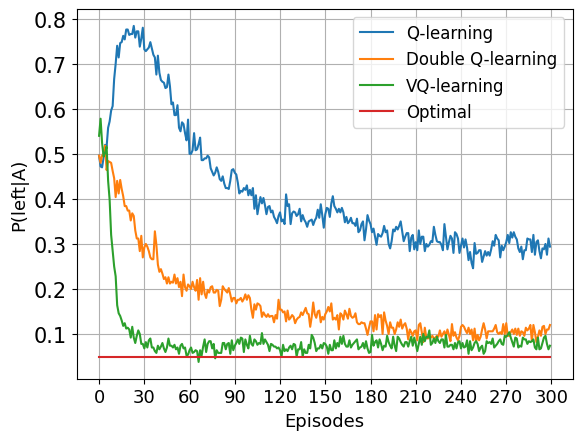

In [112]:
# a = prob_Q_A_left.mean(axis=0)
# b = prob_Q2_A_left.mean(axis=0)
# c = prob_AD_A_left.mean(axis=0)
# d = prob_E_A_left.mean(axis=0)
# e = prob_VQ_A_left.mean(axis=0)
plot_prob_A_left(prob_Q_A_left, prob_Q2_A_left, None, None, prob_VQ_A_left, std=False, note=note, save_path=save_path)
# plot_prob_A_left(prob_Q_A_left, None, None, None, None, std=False, note=note, save_path=save_path)
# plot_prob_A_left(prob_Q_A_left.mean(axis=0), prob_Q2_A_left.mean(axis=0), prob_AD_A_left.mean(axis=0), prob_E_A_left.mean(axis=0), prob_VQ_A_left.mean(axis=0))

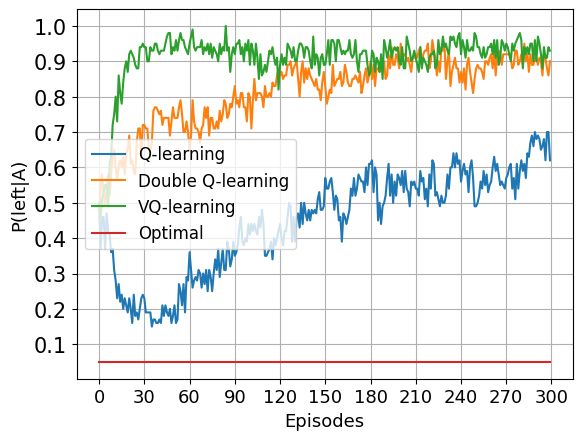

In [35]:
plot_prob_A_left(prob_Q_A_right, prob_Q2_A_right, None, None, prob_VQ_A_right, std=False, note=note, save_path=save_path)

注意有两种画图方式
- 外层循环是num_of_episodeepisodes,然后每个episode训练1w次，得出%left的概率

【问题1】每个episode下的Q表相同，如果某一步更新是left>right，则会出现抖动，Ex.100次episode之后的抖动

【问题2】从图中可以看出，前20次left的频率都在90%左右，这是因为计算某个episode下某个动作的频率实际上是计算$\epsilon-greedy$选择left的概率，由于一开始$\epsilon=0.2$，所以当Q表中left>right时，选择最优+非最优均是left的概率为$1-\epsilon + \frac{\epsilon}{|A|}=0.8+ 0.2/2=0.9$

此图能看出什么？从此图中可以看出在num_of_episode次episodes中有多少次以及训练到什么程度时Q表中的left>right(>0.8)，以及有多少次是right<left，还有$\epsilon$的衰减过程(随着episode的增加，峰值也在增加)

【问题3】采样数据时，直接使用argmax(Q),容易在初期出现极端值，因为初期的Q表是全0的空表，所以该操作会导致每次选取第一个Q值，使得在画图初期出现极端值,应该加一个判断，若每个值都相等，则等概率随机选取动作

Plot Q(A, left)

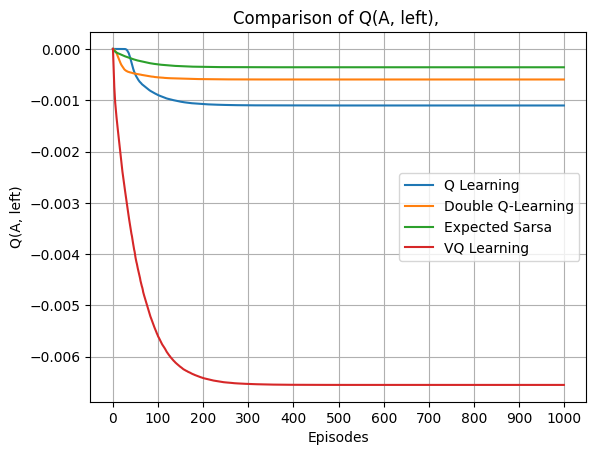

In [13]:
plot_Q_A( A_left_Q_lst, A_left_Q2_lst, None, A_left_E_lst, A_left_VQ_lst, y_label="Q(A, left)", std=False, note=note, save_path=save_path)
# plot_Q_A( A_left_Q_lst.mean(axis=0), A_left_Q2_lst.mean(axis=0), A_left_AD_lst.mean(axis=0), A_left_E_lst.mean(axis=0), A_left_VQ_lst.mean(axis=0), y_label="Q(A, left)")

Plot Q(A, right)

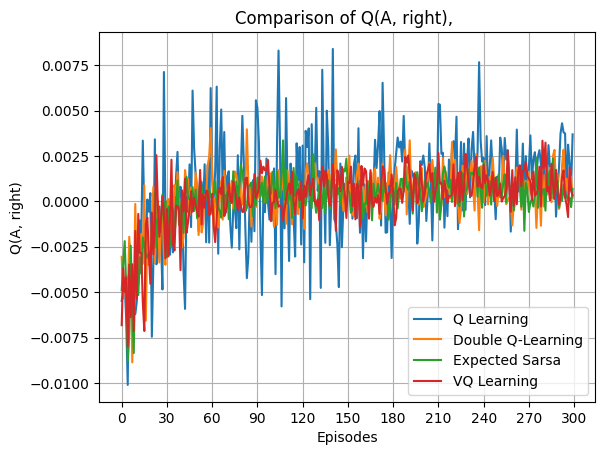

In [38]:
plot_Q_A( A_right_Q_lst, A_right_Q2_lst, None, A_right_E_lst, A_right_VQ_lst, y_label="Q(A, right)", std=False, note=note, save_path=save_path)
# plot_Q_A( A_right_Q_lst.mean(axis=0), A_right_Q2_lst.mean(axis=0), A_right_AD_lst.mean(axis=0), A_right_E_lst.mean(axis=0), A_right_VQ_lst.mean(axis=0), y_label="Q(A, right)")

Plot max_Q(B, a)

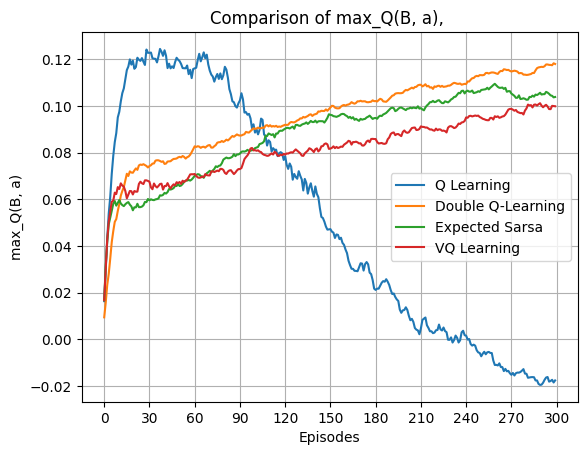

In [39]:
plot_Q_B( B_max_Q_lst, B_max_Q2_lst, None, B_max_E_lst, B_max_VQ_lst, y_label="max_Q(B, a)", std=False, note=note, save_path=save_path)
# plot_max_Q_B( B_max_Q_lst.mean(axis=0), B_max_Q2_lst.mean(axis=0), B_max_AD_lst.mean(axis=0), B_max_E_lst.mean(axis=0), B_max_VQ_lst.mean(axis=0))

Plot mean_Q(B, a)

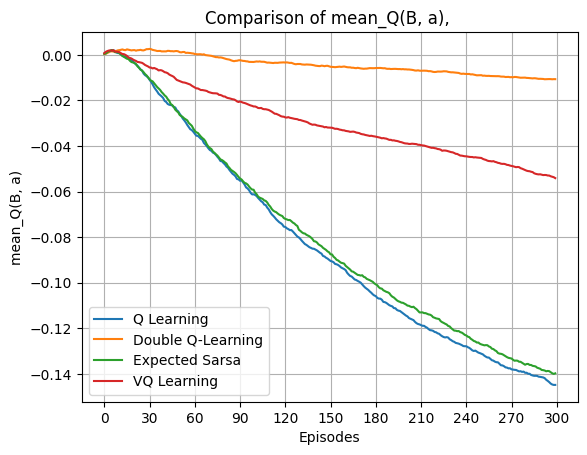

In [235]:
plot_Q_B( B_mean_Q_lst, B_mean_Q2_lst, None, B_mean_E_lst, B_mean_VQ_lst, y_label="mean_Q(B, a)", std=False, note=note, save_path=save_path)

Plot episode rewards

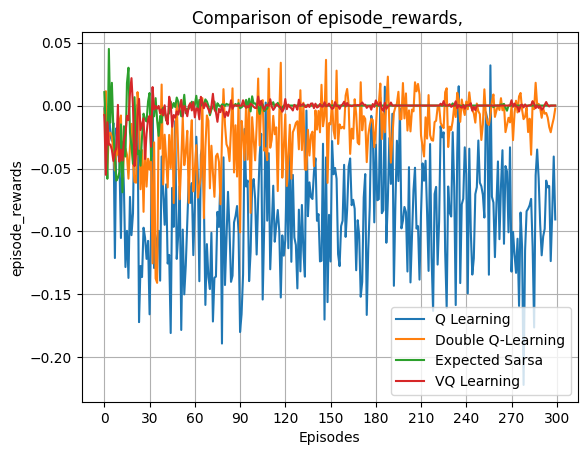

In [35]:

plot_V(R_Q_lst, R_Q2_lst, None, R_E_lst, R_VQ_lst, 'episode_rewards', std=False, note=note, save_path=save_path)
# plot_V(R_Q_lst.mean(axis=0), R_Q2_lst.mean(axis=0), R_AD_lst.mean(axis=0), R_E_lst.mean(axis=0), R_VQ_lst.mean(axis=0), 'episode_rewards', note=f"alpha={VQ_alpha}", save_path=save_path)

Plot V(A)

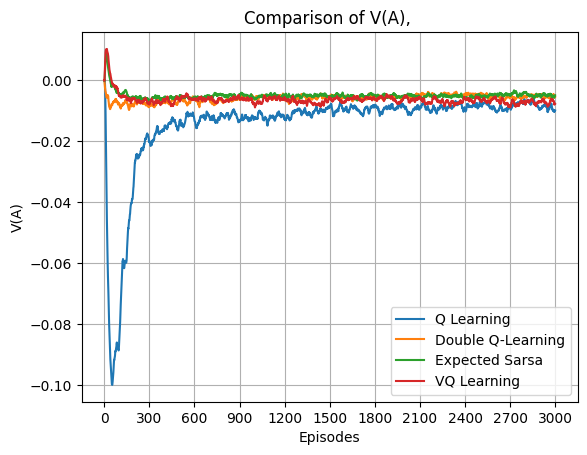

In [31]:
plot_V(V_A_Q_lst, V_A_Q2_lst, None, V_A_E_lst, V_A_VQ_lst, 'V(A)', std=False, note=note, save_path=save_path)
# plot_V(V_A_Q_lst.mean(axis=0), V_A_Q2_lst.mean(axis=0), V_A_AD_lst.mean(axis=0), V_A_E_lst.mean(axis=0), V_A_VQ_lst.mean(axis=0), 'V(A)')

Plot V(B)

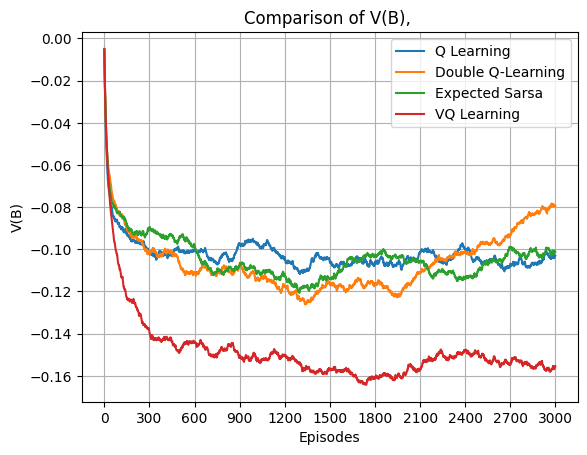

In [23]:
plot_V(V_B_Q_lst, V_B_Q2_lst, None, V_B_E_lst, V_B_VQ_lst, 'V(B)', std=False, note=note, save_path=save_path)
# plot_V(V_B_Q_lst.mean(axis=0), V_B_Q2_lst.mean(axis=0), V_B_AD_lst.mean(axis=0), V_B_E_lst.mean(axis=0), V_B_VQ_lst.mean(axis=0), 'V(B)')

Plot V(A) and Q(A, left)

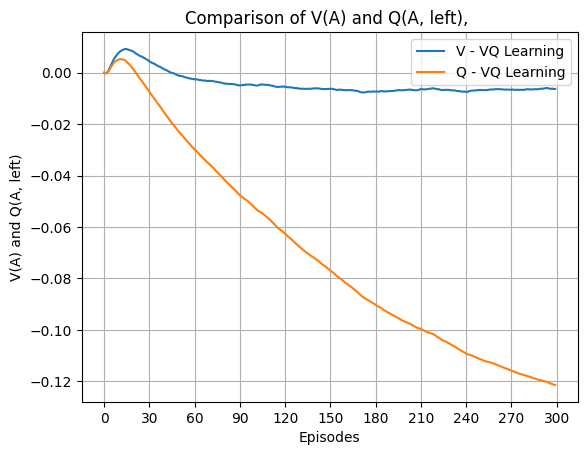

In [194]:
plot_V_Q(
    # V_Q_lst = V_A_Q_lst.mean(axis=0), 
    # Q_Q_lst = A_left_Q_lst.mean(axis=0),
    # V_Q2_lst = V_A_Q2_lst.mean(axis=0),
    # Q_Q2_lst = A_left_Q2_lst.mean(axis=0),
    # V_AD_lst = None,
    # Q_AD_lst = None,
    # V_E_lst = V_A_E_lst.mean(axis=0),
    # Q_E_lst = A_left_E_lst.mean(axis=0),
    V_VQ_lst = V_A_VQ_lst.mean(axis=0),
    Q_VQ_lst = A_left_VQ_lst.mean(axis=0),
    y_label="V(A) and Q(A, left)", 
    note=note, 
    save_path=save_path,
    )

# plot_V_Q(
#     V_A_Q_lst.mean(axis=0), 
#     A_left_Q_lst.mean(axis=0),
#     V_A_Q2_lst.mean(axis=0),
#     A_left_Q2_lst.mean(axis=0),
#     V_A_AD_lst.mean(axis=0),
#     A_left_AD_lst.mean(axis=0),
#     V_A_E_lst.mean(axis=0),
#     A_left_E_lst.mean(axis=0),
#     V_A_VQ_lst.mean(axis=0),
#     A_left_VQ_lst.mean(axis=0),
#     )

Plot V(B) and max_Q(B, _)

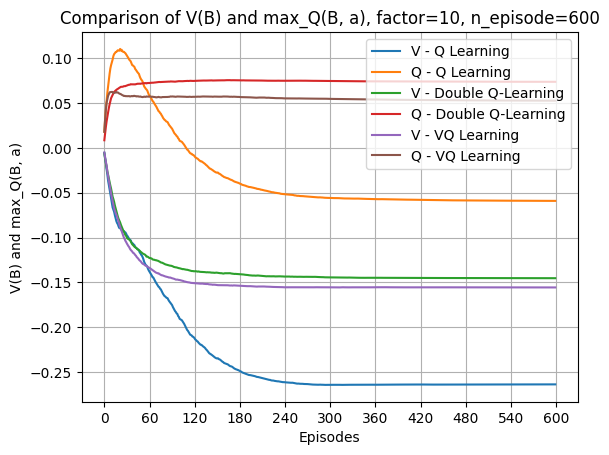

In [21]:
plot_V_Q(
    V_B_Q_lst.mean(axis=0), 
    B_max_Q_lst.mean(axis=0),
    V_B_Q2_lst.mean(axis=0),
    B_max_Q2_lst.mean(axis=0),
    None,
    None,
    None,
    None,
    V_B_VQ_lst.mean(axis=0),
    B_max_VQ_lst.mean(axis=0),
    y_label="V(B) and max_Q(B, a)", 
    note=note, 
    save_path=save_path,    
    )

# plot_V_Q(
#     V_B_Q_lst.mean(axis=0), 
#     B_max_Q_lst.mean(axis=0),
#     V_B_Q2_lst.mean(axis=0),
#     B_max_Q2_lst.mean(axis=0),
#     V_B_AD_lst.mean(axis=0),
#     B_max_AD_lst.mean(axis=0),
#     V_B_E_lst.mean(axis=0),
#     B_max_E_lst.mean(axis=0),
#     V_B_VQ_lst.mean(axis=0),
#     B_max_VQ_lst.mean(axis=0),
#     )

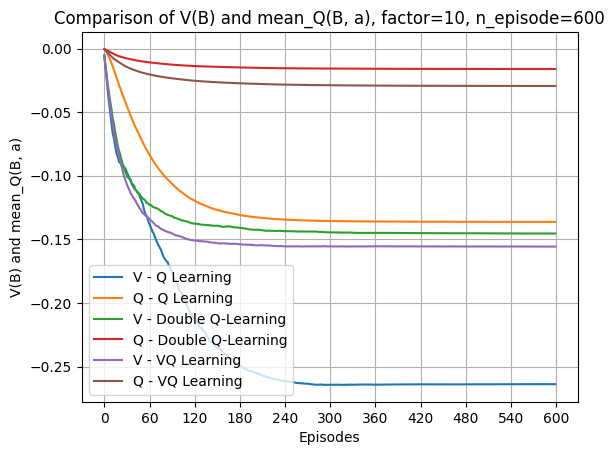

In [22]:
plot_V_Q(
    V_B_Q_lst.mean(axis=0), 
    B_mean_Q_lst.mean(axis=0),
    V_B_Q2_lst.mean(axis=0),
    B_mean_Q2_lst.mean(axis=0),
    None,
    None,
    None,
    None,
    V_B_VQ_lst.mean(axis=0),
    B_mean_VQ_lst.mean(axis=0),
    y_label="V(B) and mean_Q(B, a)", 
    note=note, 
    save_path=save_path,    
    )

Plot learning rates

/tmp/ipykernel_104943/337541280.py:18: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  action = random.sample(action_value_dict.keys(), 1)[0]


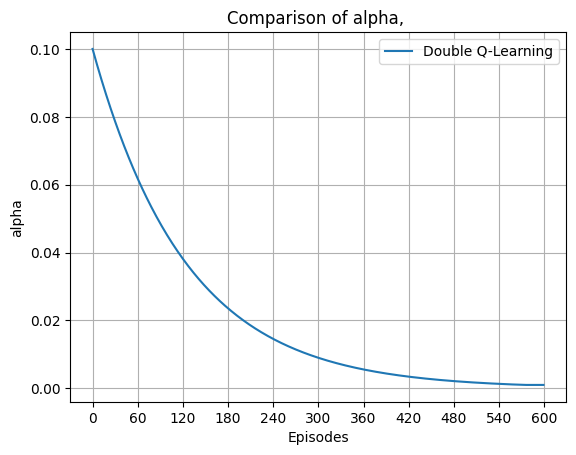

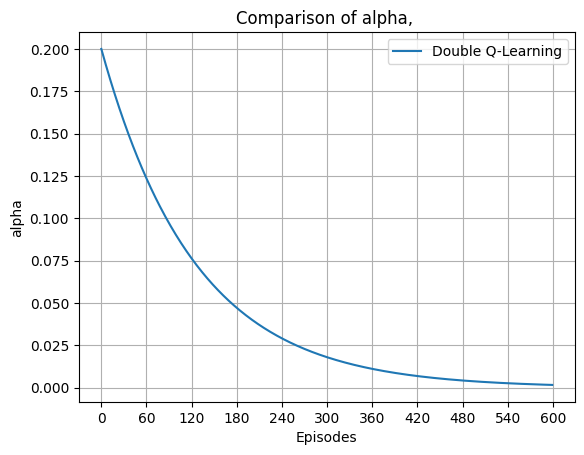

In [23]:
env = Env(-0.1, 1, 10)   
# Q-learning学习出Q表
output = TD_learning(env, method='DoubleQ', alpha_scope=[0.1, 0.001, 0.992], epsilon_scope=[0.2, 0.001,0.992], num_of_episode=num_of_episode, gamma=0.9)  
alpha_values = output['alpha_values']
epsilon_values = output['epsilon_values']
#unsqueeze alpha_values with axis=0
alpha_values = np.expand_dims(alpha_values, axis=0)
epsilon_values = np.expand_dims(epsilon_values, axis=0)

plot_V(None, alpha_values, None, None, None, 'alpha', std=False, note='', save_path=None)
plot_V(None, epsilon_values, None, None, None, 'alpha', std=False, note='', save_path=None)

/tmp/ipykernel_104943/337541280.py:18: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  action = random.sample(action_value_dict.keys(), 1)[0]


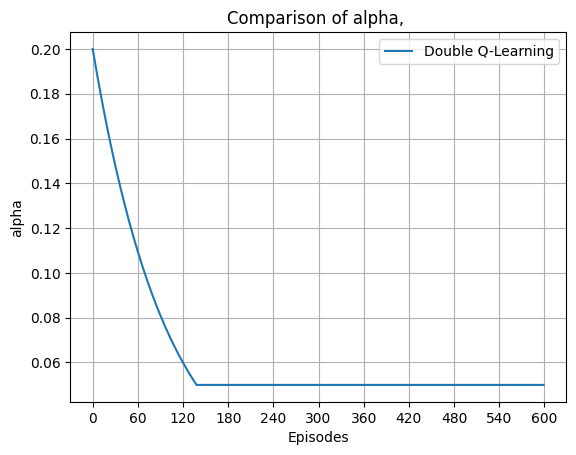

In [24]:
env = Env(-0.1, 1, 10)   
# Q-learning学习出Q表
output = TD_learning(env, method='DoubleQ', alpha_scope=[0.1, 0.005, 0.995], epsilon_scope=[0.2,0.05,0.99], num_of_episode=num_of_episode, gamma=0.9)  
epsilon_values = output['epsilon_values']
#unsqueeze alpha_values with axis=0
epsilon_values = np.expand_dims(epsilon_values, axis=0)

plot_V(None, epsilon_values, None, None, None, 'alpha', std=False, note='', save_path=None)